In [1]:
!pip install modAL seqlogo
!apt install ghostscript python3-tk
from ctypes.util import find_library
find_library("gs")

     |████████████████████████████████| 466 kB 5.1 MB/s 
  Created wheel for seqlogo: filename=seqlogo-5.29.8-py2.py3-none-any.whl size=19419 sha256=fb32784d66dcdbf5f4ebeb1fc5df8209d00d4a0b0adfe0013247129b88667185
  Stored in directory: /root/.cache/pip/wheels/7d/59/83/8ade9d6ad92869424ccbd6cffd6cbe84440f5e7bcaa82d7aff
Successfully built seqlogo
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-tk is already the newest version (3.6.9-1~18.04).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono gsfonts libcupsfilters1 libcupsimage2
  libgs9 libgs9-common libijs-0.35 libjbig2dec0 poppler-data
Suggested packages:
  fonts-noto ghostscript-x poppler-utils fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafo

'libgs.so.9'

In [7]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, roc_curve, matthews_corrcoef

from sklearn.svm import SVR

from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process.kernels import Matern, RBF,WhiteKernel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from modAL.models import BayesianOptimizer, ActiveLearner, CommitteeRegressor
from modAL.acquisition import max_EI, max_UCB
from modAL.uncertainty import classifier_uncertainty
from modAL.disagreement import max_disagreement_sampling, vote_entropy_sampling, max_std_sampling
from modAL.density import information_density

from keras.models import Sequential
from keras.layers import Dense

import seqlogo

import copy

### Set randome seed
seed = 5
random.seed(seed)
np.random.seed(seed)

# Reading and Processing the Data¶

In [3]:
from google.colab import drive, files
from pathlib import Path
import sys, os
drive.mount('/content/drive', force_remount = True)
# path
proj_path = Path("/content/drive/MyDrive/LMAB/LMAB2/phenotype project")
data_path = proj_path/"data"
output_path = proj_path/"output"
def mkdir_if_ne(path):
    if not os.path.exists(path): os.mkdir(path)
mkdir_if_ne(output_path)
mkdir_if_ne(data_path)
print(f"proj_path: {data_path}")
sys.path.append(str(data_path.parent))

Mounted at /content/drive
proj_path: /content/drive/MyDrive/LMAB/LMAB2/phenotype project/data


In [4]:
our_sim_df = pd.read_csv(data_path/"raw"/"Our_drug_simulation_dataset(reduced).csv", index_col=0).drop_duplicates()
research_sim_df = pd.read_csv(data_path/"raw"/"previous_research_dataset.csv").drop_duplicates()
print(our_sim_df.shape, research_sim_df.shape)
research_sim_df.head(2)

(1296, 5) (100, 3)


,Ibrutinib,BKM-120,Cell viability
0,0.0,0,1.00
1,0.0,20,0.93


In [5]:
df_data = our_sim_df
# Inverse target sign
df_data.iloc[:,-1] = -df_data.iloc[:,-1]
# df_data = pd.read_csv(str(data_path/'DataPool.csv'), dtype = float, delimiter = ',').dropna(axis=0)
df_data.head(2)

,(+)-Griseofulvin,(S)-(+)-Camptothecin,Chloramphenicol,Metformin,Cell viability
0,128.0,32.0,3200.0,512.0,-0.000
1,128.0,32.0,3200.0,256.0,-0.825


In [6]:
scaler = StandardScaler()
df_data_scaled = pd.DataFrame(scaler.fit_transform(df_data),columns=df_data.columns)
print("data size", df_data.shape); df_data_scaled.head(2)

data size (1296, 5)


,(+)-Griseofulvin,(S)-(+)-Camptothecin,Chloramphenicol,Metformin,Cell viability
0,1.985556,1.985556,1.985556,1.985556,2.381123
1,1.985556,1.985556,1.985556,0.507933,-0.412759


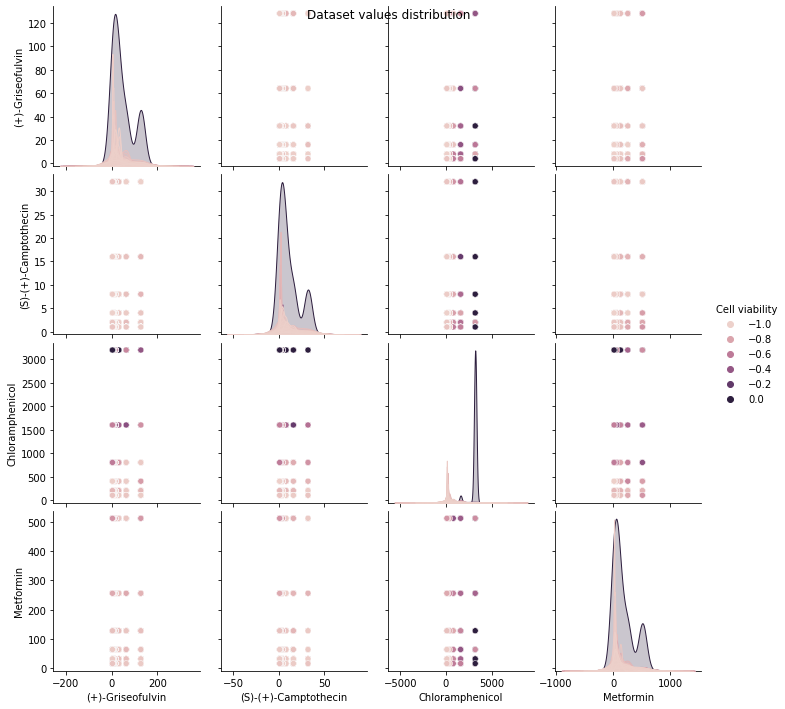

In [30]:
# Visualize dataset
fig_pairplot = sb.pairplot(df_data, hue='Cell viability')
plt.suptitle("Dataset values distribution")
fig_pairplot.savefig(output_path/"Dataset Pairplot.jpg")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_data_scaled.iloc[:,:-1].to_numpy(), pd.DataFrame(df_data_scaled.iloc[:,-1]).to_numpy(), random_state=seed, shuffle=True, test_size=0.2)


In [ ]:
print("Number of examples (budget):",X_train.shape)
# initial samples
X_cp = copy.deepcopy(np.array(X_train)); y_cp = copy.deepcopy(np.array(y_train))
initial_idx = np.random.choice(range(len(X_cp)), size=10, replace=False)
X_training, y_training = X_cp[initial_idx], y_cp[initial_idx].reshape(-1,1)

Number of examples (budget): (1036, 4)


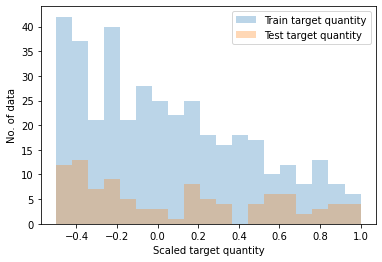

In [ ]:
# Check data skew
bins = np.linspace(-.5, 1, 20);plt.xlabel("Scaled target quantity"); plt.ylabel("No. of data")
plt.hist(y_train, bins, alpha=0.3, label="Train target quantity")
plt.hist(y_test, bins, alpha=0.3, label="Test target quantity"); 
plt.legend(loc='upper right'); plt.show()

### Custom Query methods

In [ ]:
def random_query(classifier, X, **kargs):
    ran_idx = random.choice(range(len(X)))
    return ran_idx, X[ran_idx]

def ensemble_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

def density_query(regressor, X):
  euclidean_density = information_density(X, 'euclidean')
  _, utility = regressor.predict(X, return_std=True,)
  gain = euclidean_density * utility
  idx = np.argmax(gain)
  return idx, X[idx]

### Random Query RF: Basline

In [ ]:
    # Random RF learner
rf_rand = ActiveLearner(
    estimator=RandomForestRegressor(),
    query_strategy=random_query,
    X_training=X_training, y_training=y_training)

lr_rand = ActiveLearner(
    estimator=RandomForestRegressor(),
    query_strategy=random_query,
    X_training=X_training, y_training=y_training)

/usr/local/lib/python3.7/dist-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)
/usr/local/lib/python3.7/dist-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)


# Baysian Optimization with Gaussian Process


### Bayesian Optimizer


In [ ]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
#warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [ ]:
# Bayesian Optimizer
# with GP
bayes_gp_maxei = BayesianOptimizer(
    estimator=GaussianProcessRegressor(kernel=Matern(length_scale=1,length_scale_bounds=(1e-2, 1e2))),
    query_strategy=max_EI,
    X_training=X_training, y_training=y_training
)
bayes_gp_rand = BayesianOptimizer(
    estimator=GaussianProcessRegressor(kernel=Matern(length_scale=1,length_scale_bounds=(1e-2, 1e2))),
    query_strategy=random_query,
    X_training=X_training, y_training=y_training
)
#with Random Forest
class rfwapper(RandomForestRegressor):
    def predict(self, X, return_std = False):
      ys = np.array([e.predict(X) for e in self.estimators_])
      if return_std:
          return np.mean(ys, axis = 0).ravel(), np.nanstd(ys, axis = 0).ravel()
      return super().predict(X).ravel()
bayes_rf_maxei = BayesianOptimizer(
    estimator=rfwapper(),
    query_strategy=max_EI,
    X_training=X_training, y_training=y_training
)
bayes_rf_rand = BayesianOptimizer(
    estimator=rfwapper(),
    query_strategy=random_query,
    X_training=X_training, y_training=y_training
)


### NN Ensemble classification



In [ ]:
from keras import Sequential
from keras.layers import Dense , Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.initializers import he_normal,glorot_normal
#from keras.utils import plot_model

In [ ]:
n_feat = X_training.shape[1]
def create_dense_model():
  model = Sequential()
  model.add(Dense(10,input_shape=(n_feat,), kernel_initializer=he_normal))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(100, ))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(100, ))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(20))
  model.add(BatchNormalization())
  model.add(Activation('linear'))
  model.add(Dense(1))
  model.compile(optimizer='adam',loss='mse')
  return model
create_dense_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 batch_normalization (BatchN  (None, 10)               40        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 100)               1100      
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 100)               0

In [ ]:
# NN Ensemble learner
def nn_ensemble_learner(n_clf=5):
  learner_list = []
  for i in range(n_clf):
    #classifier = MLPRegressor(hidden_layer_sizes=(10,100,100,20), activation='relu', 
     #                         solver='sgd', early_stopping=False, verbose=0)
    classifier = create_dense_model()
    # initializing learner
    learner = ActiveLearner(
        estimator=classifier,
        X_training= X_training, y_training= y_training)
    learner_list.append(learner)
  return learner_list

# assembling the committee
nn_learner_committee_rand = CommitteeRegressor(
      learner_list=nn_ensemble_learner(),
      query_strategy=random_query)
  # ensemble std
nn_learner_committee_std = CommitteeRegressor(
      learner_list=nn_ensemble_learner(),
      query_strategy=max_std_sampling)
  # max UCB
nn_learner_committee_UCB = CommitteeRegressor(
      learner_list=nn_ensemble_learner(),
      query_strategy=max_UCB)
  # Density
'''
nn_learner_committee_dense = CommitteeRegressor(
      learner_list=nn_ensemble_learner(),
      query_strategy=density_query)
'''

1/1 [==============================] - 1s 1s/step - loss: 2.0342


'\nnn_learner_committee_dense = CommitteeRegressor(\n      learner_list=nn_ensemble_learner(),\n      query_strategy=density_query)\n'

In [ ]:
# regression committees
def make_learners(classifiers=[SVR(), RandomForestRegressor(max_depth=6), GradientBoostingRegressor(), LinearRegression()]):
  learner_list = []
  for classifier in classifiers:
      # initializing learner
    learner_list.append(
        ActiveLearner(
        estimator=classifier,
        X_training= X_training, y_training= y_training)
      )
  # assembling the committee
  return learner_list
# 
ensemble_4regressor_std = CommitteeRegressor(learner_list=make_learners(), query_strategy=max_std_sampling)
ensemble_4regressor_dense = CommitteeRegressor(learner_list=make_learners(), query_strategy=density_query)

In [ ]:
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]
######### GP processes ensemble
gpr1 = GaussianProcessRegressor(kernel=Matern(length_scale=1))
gpr2 = GaussianProcessRegressor(kernel=RBF(length_scale=1.0))
classifiers = [gpr1, gpr2]; learner_list = []
for classifier in classifiers:
    # initializing learner
    learner = ActiveLearner(
        estimator=classifier,
        X_training= X_training, y_training= y_training)
    learner_list.append(learner)

# assembling the committee
gp_committee_2_std = CommitteeRegressor(
      learner_list=learner_list,
      query_strategy=max_std_sampling)
gp_committee_2_dense = CommitteeRegressor(
      learner_list=learner_list,
      query_strategy=density_query)
# initializing the regressors
n_initial = 10
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

learner_list = [ActiveLearner(estimator=GaussianProcessRegressor(kernel),
                              X_training=X_training, y_training=y_training) 
                for idx in initial_idx]
gp_committee_10_std = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy=max_std_sampling)

In [ ]:
print(X_train.shape)

(1036, 4)


(1036, 4) (1036, 1)
Query round 0 |Remaining Data Shape (1036, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (4, 4) (4, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


25 Test R2: Bayesian GP - Random 0.2757089286719506
Training data used: 100
25 Test R2: Bayesian GP - Max EI 0.061230141383275205
Training data used: 100
25 Test R2: Bayesian RF - Random 0.37857866732069856
Training data used: 100
25 Test R2: Bayesian RF - Max EI 0.45578146120393304
Training data used: 100
Query round 26 |Remaining Data Shape (906, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


26 Test R2: Bayesian GP - Random -2.7493006502510298e-05
Training data used: 104
26 Test R2: Bayesian GP - Max EI 0.062409380728359554
Training data used: 104
26 Test R2: Bayesian RF - Random 0.4036116962996127
Training data used: 104
26 Test R2: Bayesian RF - Max EI 0.4543425493270008
Training data used: 104
Query round 27 |Remaining Data Shape (901, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


27 Test R2: Bayesian GP - Random -2.749301283433425e-05
Training data used: 108
27 Test R2: Bayesian GP - Max EI 0.0628094050610355
Training data used: 108
27 Test R2: Bayesian RF - Random 0.387449812824181
Training data used: 108
27 Test R2: Bayesian RF - Max EI 0.44428089855939357
Training data used: 108
Query round 28 |Remaining Data Shape (896, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


28 Test R2: Bayesian GP - Random -2.7481365176384998e-05
Training data used: 112
28 Test R2: Bayesian GP - Max EI 0.05809519455041745
Training data used: 112
28 Test R2: Bayesian RF - Random 0.4032581490993661
Training data used: 112
28 Test R2: Bayesian RF - Max EI 0.4488856015516721
Training data used: 112
Query round 29 |Remaining Data Shape (891, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


29 Test R2: Bayesian GP - Random -2.7466010041443667e-05
Training data used: 116
29 Test R2: Bayesian GP - Max EI 0.05775661655535447
Training data used: 116
29 Test R2: Bayesian RF - Random 0.4002657254124301
Training data used: 116
29 Test R2: Bayesian RF - Max EI 0.4454133068106574
Training data used: 116
Query round 30 |Remaining Data Shape (886, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


30 Test R2: Bayesian GP - Random -2.7442199204141815e-05
Training data used: 120
30 Test R2: Bayesian GP - Max EI 0.07967599876639009
Training data used: 120
30 Test R2: Bayesian RF - Random 0.37624566566607887
Training data used: 120
30 Test R2: Bayesian RF - Max EI 0.43867884305688554
Training data used: 120
Query round 31 |Remaining Data Shape (881, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Ran

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


31 Test R2: Bayesian GP - Random -2.7442198734961565e-05
Training data used: 124
31 Test R2: Bayesian GP - Max EI 0.07981856546193244
Training data used: 124
31 Test R2: Bayesian RF - Random 0.39481172064243186
Training data used: 124
31 Test R2: Bayesian RF - Max EI 0.4417694079315342
Training data used: 124
Query round 32 |Remaining Data Shape (876, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


32 Test R2: Bayesian GP - Random -2.7387806928347302e-05
Training data used: 128
32 Test R2: Bayesian GP - Max EI 0.08136448213607439
Training data used: 128
32 Test R2: Bayesian RF - Random 0.3835916505588609
Training data used: 128
32 Test R2: Bayesian RF - Max EI 0.4170185739101676
Training data used: 128
Query round 33 |Remaining Data Shape (871, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


33 Test R2: Bayesian GP - Random -2.7380208221794433e-05
Training data used: 132
33 Test R2: Bayesian GP - Max EI 0.06853278862917245
Training data used: 132
33 Test R2: Bayesian RF - Random 0.39398240844068033
Training data used: 132
33 Test R2: Bayesian RF - Max EI 0.4062556501569703
Training data used: 132
Query round 34 |Remaining Data Shape (866, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


34 Test R2: Bayesian GP - Random -2.7380208233118708e-05
Training data used: 136
34 Test R2: Bayesian GP - Max EI 0.0668978146491328
Training data used: 136
34 Test R2: Bayesian RF - Random 0.39479401674923
Training data used: 136
34 Test R2: Bayesian RF - Max EI 0.3837839060396693
Training data used: 136
Query round 35 |Remaining Data Shape (861, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
M

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


35 Test R2: Bayesian GP - Random -2.7313762277270115e-05
Training data used: 140
35 Test R2: Bayesian GP - Max EI 0.0701797457219121
Training data used: 140
35 Test R2: Bayesian RF - Random 0.39460137944540474
Training data used: 140
35 Test R2: Bayesian RF - Max EI 0.3873828463275165
Training data used: 140
Query round 36 |Remaining Data Shape (856, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


36 Test R2: Bayesian GP - Random -2.731371483055689e-05
Training data used: 144
36 Test R2: Bayesian GP - Max EI 0.0844098930264211
Training data used: 144
36 Test R2: Bayesian RF - Random 0.38563254569684935
Training data used: 144
36 Test R2: Bayesian RF - Max EI 0.42677303086427676
Training data used: 144
Query round 37 |Remaining Data Shape (851, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


37 Test R2: Bayesian GP - Random -2.7291383631222743e-05
Training data used: 148
37 Test R2: Bayesian GP - Max EI 0.08383987183841302
Training data used: 148
37 Test R2: Bayesian RF - Random 0.3693302890556388
Training data used: 148
37 Test R2: Bayesian RF - Max EI 0.4162089114134444
Training data used: 148
Query round 38 |Remaining Data Shape (846, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


38 Test R2: Bayesian GP - Random -2.7286100263701485e-05
Training data used: 152
38 Test R2: Bayesian GP - Max EI 0.09113671634615761
Training data used: 152
38 Test R2: Bayesian RF - Random 0.3788090790120586
Training data used: 152
38 Test R2: Bayesian RF - Max EI 0.42018263975225967
Training data used: 152
Query round 39 |Remaining Data Shape (841, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


39 Test R2: Bayesian GP - Random -2.728605122137573e-05
Training data used: 156
39 Test R2: Bayesian GP - Max EI 0.09837819785733015
Training data used: 156
39 Test R2: Bayesian RF - Random 0.3747218710457427
Training data used: 156
39 Test R2: Bayesian RF - Max EI 0.39195233538538543
Training data used: 156
Query round 40 |Remaining Data Shape (836, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


40 Test R2: Bayesian GP - Random -2.7275922632297167e-05
Training data used: 160
40 Test R2: Bayesian GP - Max EI 0.09586318638672697
Training data used: 160
40 Test R2: Bayesian RF - Random 0.36414967838509626
Training data used: 160
40 Test R2: Bayesian RF - Max EI 0.4075412401089338
Training data used: 160
Query round 41 |Remaining Data Shape (831, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


41 Test R2: Bayesian GP - Random -2.729235141551989e-05
Training data used: 164
41 Test R2: Bayesian GP - Max EI 0.09597575156847549
Training data used: 164
41 Test R2: Bayesian RF - Random 0.35548804056425465
Training data used: 164
41 Test R2: Bayesian RF - Max EI 0.4177549410016065
Training data used: 164
Query round 42 |Remaining Data Shape (826, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


42 Test R2: Bayesian GP - Random -2.7292259857647494e-05
Training data used: 168
42 Test R2: Bayesian GP - Max EI 0.09392584828064099
Training data used: 168
42 Test R2: Bayesian RF - Random 0.37350915986915445
Training data used: 168
42 Test R2: Bayesian RF - Max EI 0.3524264408053339
Training data used: 168
Query round 43 |Remaining Data Shape (821, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


43 Test R2: Bayesian GP - Random -2.7282297160313718e-05
Training data used: 172
43 Test R2: Bayesian GP - Max EI 0.08884973683495812
Training data used: 172
43 Test R2: Bayesian RF - Random 0.35681123506320733
Training data used: 172
43 Test R2: Bayesian RF - Max EI 0.3639721577010133
Training data used: 172
Query round 44 |Remaining Data Shape (816, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


44 Test R2: Bayesian GP - Random -2.7272686405455104e-05
Training data used: 176
44 Test R2: Bayesian GP - Max EI 0.09194038090999423
Training data used: 176
44 Test R2: Bayesian RF - Random 0.4172935880337747
Training data used: 176
44 Test R2: Bayesian RF - Max EI 0.3987969582616654
Training data used: 176
Query round 45 |Remaining Data Shape (811, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


45 Test R2: Bayesian GP - Random -2.7272686180745964e-05
Training data used: 180
45 Test R2: Bayesian GP - Max EI 0.07994435226706575
Training data used: 180
45 Test R2: Bayesian RF - Random 0.42997296520191897
Training data used: 180
45 Test R2: Bayesian RF - Max EI 0.38050870379833845
Training data used: 180
Query round 46 |Remaining Data Shape (806, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Ran

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


46 Test R2: Bayesian GP - Random -2.7272636227371194e-05
Training data used: 184
46 Test R2: Bayesian GP - Max EI 0.07978029579031953
Training data used: 184
46 Test R2: Bayesian RF - Random 0.4066925337806129
Training data used: 184
46 Test R2: Bayesian RF - Max EI 0.38825031900276896
Training data used: 184
Query round 47 |Remaining Data Shape (801, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


47 Test R2: Bayesian GP - Random -2.7265658491648637e-05
Training data used: 188
47 Test R2: Bayesian GP - Max EI 0.0794417119248858
Training data used: 188
47 Test R2: Bayesian RF - Random 0.40416453120682716
Training data used: 188
47 Test R2: Bayesian RF - Max EI 0.37822953476220433
Training data used: 188
Query round 48 |Remaining Data Shape (796, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


48 Test R2: Bayesian GP - Random -2.7265608085746962e-05
Training data used: 192
48 Test R2: Bayesian GP - Max EI 0.07953921385065621
Training data used: 192
48 Test R2: Bayesian RF - Random 0.4213685593130191
Training data used: 192
48 Test R2: Bayesian RF - Max EI 0.36453967521403186
Training data used: 192
Query round 49 |Remaining Data Shape (791, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


49 Test R2: Bayesian GP - Random -2.7265608049331647e-05
Training data used: 196
49 Test R2: Bayesian GP - Max EI 0.08143335814407926
Training data used: 196
49 Test R2: Bayesian RF - Random 0.40382311342957244
Training data used: 196
49 Test R2: Bayesian RF - Max EI 0.39505642511276295
Training data used: 196
Query round 50 |Remaining Data Shape (786, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Ran

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


50 Test R2: Bayesian GP - Random -2.7265640685225634e-05
Training data used: 200
50 Test R2: Bayesian GP - Max EI 0.08228416257620141
Training data used: 200
50 Test R2: Bayesian RF - Random 0.3810406075485798
Training data used: 200
50 Test R2: Bayesian RF - Max EI 0.37203656944430563
Training data used: 200
Query round 51 |Remaining Data Shape (781, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


51 Test R2: Bayesian GP - Random -2.7265640695883775e-05
Training data used: 204
51 Test R2: Bayesian GP - Max EI 0.08465494171903942
Training data used: 204
51 Test R2: Bayesian RF - Random 0.36479640552373593
Training data used: 204
51 Test R2: Bayesian RF - Max EI 0.37143950317556496
Training data used: 204
Query round 52 |Remaining Data Shape (776, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Ran

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


53 Test R2: Bayesian GP - Random -2.7246448722983985e-05
Training data used: 212
53 Test R2: Bayesian GP - Max EI 0.08196010727550196
Training data used: 212
53 Test R2: Bayesian RF - Random 0.3509366956224165
Training data used: 212
53 Test R2: Bayesian RF - Max EI 0.36403879068664413
Training data used: 212
Query round 54 |Remaining Data Shape (766, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


54 Test R2: Bayesian GP - Random -2.7239479976515213e-05
Training data used: 216
54 Test R2: Bayesian GP - Max EI 0.08295374796536281
Training data used: 216
54 Test R2: Bayesian RF - Random 0.4016933499411727
Training data used: 216
54 Test R2: Bayesian RF - Max EI 0.37383756531405177
Training data used: 216
Query round 55 |Remaining Data Shape (761, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


56 Test R2: Bayesian GP - Random -2.7239479990059934e-05
Training data used: 224
56 Test R2: Bayesian GP - Max EI 0.08017783370527043
Training data used: 224
56 Test R2: Bayesian RF - Random 0.37013683493973026
Training data used: 224
56 Test R2: Bayesian RF - Max EI 0.38928999505385753
Training data used: 224
Query round 57 |Remaining Data Shape (751, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Ran

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


57 Test R2: Bayesian GP - Random -2.723855853026258e-05
Training data used: 228
57 Test R2: Bayesian GP - Max EI 0.07977016692440786
Training data used: 228
57 Test R2: Bayesian RF - Random 0.3919900558733672
Training data used: 228
57 Test R2: Bayesian RF - Max EI 0.3820422104432706
Training data used: 228
Query round 58 |Remaining Data Shape (746, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


58 Test R2: Bayesian GP - Random -2.7225290125221235e-05
Training data used: 232
58 Test R2: Bayesian GP - Max EI 0.08184469062385469
Training data used: 232
58 Test R2: Bayesian RF - Random 0.3901725255175681
Training data used: 232
58 Test R2: Bayesian RF - Max EI 0.39425390598953225
Training data used: 232
Query round 59 |Remaining Data Shape (741, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


59 Test R2: Bayesian GP - Random -2.72216920889079e-05
Training data used: 236
59 Test R2: Bayesian GP - Max EI 0.08148139763361806
Training data used: 236
59 Test R2: Bayesian RF - Random 0.390100487164455
Training data used: 236
59 Test R2: Bayesian RF - Max EI 0.3846966627659534
Training data used: 236
Query round 60 |Remaining Data Shape (736, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
M

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


60 Test R2: Bayesian GP - Random -2.7223890730621036e-05
Training data used: 240
60 Test R2: Bayesian GP - Max EI 0.08137233801601629
Training data used: 240
60 Test R2: Bayesian RF - Random 0.37427897280241174
Training data used: 240
60 Test R2: Bayesian RF - Max EI 0.37819455497069643
Training data used: 240
Query round 61 |Remaining Data Shape (731, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Ran

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


62 Test R2: Bayesian GP - Random -2.7258704825783298e-05
Training data used: 248
62 Test R2: Bayesian GP - Max EI 0.08213550181615237
Training data used: 248
62 Test R2: Bayesian RF - Random 0.3881200068667996
Training data used: 248
62 Test R2: Bayesian RF - Max EI 0.36634079721615287
Training data used: 248
Query round 63 |Remaining Data Shape (721, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


63 Test R2: Bayesian GP - Random -2.725870488373694e-05
Training data used: 252
63 Test R2: Bayesian GP - Max EI 0.08376030754476249
Training data used: 252
63 Test R2: Bayesian RF - Random 0.4033684384273505
Training data used: 252
63 Test R2: Bayesian RF - Max EI 0.36138017589203486
Training data used: 252
Query round 64 |Remaining Data Shape (716, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


64 Test R2: Bayesian GP - Random -2.7254426585354707e-05
Training data used: 256
64 Test R2: Bayesian GP - Max EI 0.08376491255135932
Training data used: 256
64 Test R2: Bayesian RF - Random 0.4225558384524605
Training data used: 256
64 Test R2: Bayesian RF - Max EI 0.3636816621001481
Training data used: 256
Query round 65 |Remaining Data Shape (711, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


65 Test R2: Bayesian GP - Random -2.725421719085297e-05
Training data used: 260
65 Test R2: Bayesian GP - Max EI 0.086541486582847
Training data used: 260
65 Test R2: Bayesian RF - Random 0.4343999468365394
Training data used: 260
65 Test R2: Bayesian RF - Max EI 0.37389250198022184
Training data used: 260
Query round 66 |Remaining Data Shape (706, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


66 Test R2: Bayesian GP - Random -2.7254217380257018e-05
Training data used: 264
66 Test R2: Bayesian GP - Max EI 0.08831037020070442
Training data used: 264
66 Test R2: Bayesian RF - Random 0.4237321902989385
Training data used: 264
66 Test R2: Bayesian RF - Max EI 0.3723225157624048
Training data used: 264
Query round 67 |Remaining Data Shape (701, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


67 Test R2: Bayesian GP - Random -2.721348750656105e-05
Training data used: 268
67 Test R2: Bayesian GP - Max EI 0.09350415265484513
Training data used: 268
67 Test R2: Bayesian RF - Random 0.43311781957272244
Training data used: 268
67 Test R2: Bayesian RF - Max EI 0.3897389709248158
Training data used: 268
Query round 68 |Remaining Data Shape (696, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


68 Test R2: Bayesian GP - Random -2.720699682057237e-05
Training data used: 272
68 Test R2: Bayesian GP - Max EI 0.09619782475737959
Training data used: 272
68 Test R2: Bayesian RF - Random 0.44162868388795073
Training data used: 272
68 Test R2: Bayesian RF - Max EI 0.35529423352967615
Training data used: 272
Query round 69 |Remaining Data Shape (691, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


69 Test R2: Bayesian GP - Random -2.7204224739785232e-05
Training data used: 276
69 Test R2: Bayesian GP - Max EI 0.09673898068181741
Training data used: 276
69 Test R2: Bayesian RF - Random 0.4360719317319275
Training data used: 276
69 Test R2: Bayesian RF - Max EI 0.38491495848763635
Training data used: 276
Query round 70 |Remaining Data Shape (686, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


70 Test R2: Bayesian GP - Random -2.719824577823715e-05
Training data used: 280
70 Test R2: Bayesian GP - Max EI 0.0993749123991049
Training data used: 280
70 Test R2: Bayesian RF - Random 0.43256324433817606
Training data used: 280
70 Test R2: Bayesian RF - Max EI 0.3650489655648046
Training data used: 280
Query round 71 |Remaining Data Shape (681, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


72 Test R2: Bayesian GP - Random -2.7172476964265613e-05
Training data used: 288
72 Test R2: Bayesian GP - Max EI 0.10353524945221215
Training data used: 288
72 Test R2: Bayesian RF - Random 0.430549124825643
Training data used: 288
72 Test R2: Bayesian RF - Max EI 0.370854360961819
Training data used: 288
Query round 73 |Remaining Data Shape (671, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


74 Test R2: Bayesian GP - Random -2.7138815619220935e-05
Training data used: 296
74 Test R2: Bayesian GP - Max EI 0.10363641541745483
Training data used: 296
74 Test R2: Bayesian RF - Random 0.42029378957460983
Training data used: 296
74 Test R2: Bayesian RF - Max EI 0.3633698988756887
Training data used: 296
Query round 75 |Remaining Data Shape (661, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


75 Test R2: Bayesian GP - Random -2.713942428900218e-05
Training data used: 300
75 Test R2: Bayesian GP - Max EI 0.11591251682742898
Training data used: 300
75 Test R2: Bayesian RF - Random 0.42844973989237334
Training data used: 300
75 Test R2: Bayesian RF - Max EI 0.35729298570238854
Training data used: 300
Query round 76 |Remaining Data Shape (656, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


76 Test R2: Bayesian GP - Random -2.7133588115235696e-05
Training data used: 304
76 Test R2: Bayesian GP - Max EI 0.1152001198580036
Training data used: 304
76 Test R2: Bayesian RF - Random 0.4232011606171898
Training data used: 304
76 Test R2: Bayesian RF - Max EI 0.38212666026004705
Training data used: 304
Query round 77 |Remaining Data Shape (651, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


77 Test R2: Bayesian GP - Random -2.711721617565388e-05
Training data used: 308
77 Test R2: Bayesian GP - Max EI 0.11619721769872526
Training data used: 308
77 Test R2: Bayesian RF - Random 0.41588899490217746
Training data used: 308
77 Test R2: Bayesian RF - Max EI 0.38385536943833065
Training data used: 308
Query round 78 |Remaining Data Shape (646, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


78 Test R2: Bayesian GP - Random -2.7118736712905545e-05
Training data used: 312
78 Test R2: Bayesian GP - Max EI 0.1284486719115827
Training data used: 312
78 Test R2: Bayesian RF - Random 0.4386908920361322
Training data used: 312
78 Test R2: Bayesian RF - Max EI 0.35606179926320547
Training data used: 312
Query round 79 |Remaining Data Shape (641, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


79 Test R2: Bayesian GP - Random -2.7118692354832774e-05
Training data used: 316
79 Test R2: Bayesian GP - Max EI 0.13498961433625356
Training data used: 316
79 Test R2: Bayesian RF - Random 0.42635964421393613
Training data used: 316
79 Test R2: Bayesian RF - Max EI 0.35619462523600354
Training data used: 316
Query round 80 |Remaining Data Shape (636, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Ran

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


81 Test R2: Bayesian GP - Random -2.710962649854487e-05
Training data used: 324
81 Test R2: Bayesian GP - Max EI 0.13922157002336844
Training data used: 324
81 Test R2: Bayesian RF - Random 0.4143170147158809
Training data used: 324
81 Test R2: Bayesian RF - Max EI 0.3673067373155243
Training data used: 324
Query round 82 |Remaining Data Shape (626, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


82 Test R2: Bayesian GP - Random -2.7098323834851e-05
Training data used: 328
82 Test R2: Bayesian GP - Max EI 0.14327091930181635
Training data used: 328
82 Test R2: Bayesian RF - Random 0.42262842478867524
Training data used: 328
82 Test R2: Bayesian RF - Max EI 0.3586440299130266
Training data used: 328
Query round 83 |Remaining Data Shape (621, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


83 Test R2: Bayesian GP - Random -2.7071500615427624e-05
Training data used: 332
83 Test R2: Bayesian GP - Max EI 0.14901633554754623
Training data used: 332
83 Test R2: Bayesian RF - Random 0.4355732419630921
Training data used: 332
83 Test R2: Bayesian RF - Max EI 0.3815210484527899
Training data used: 332
Query round 84 |Remaining Data Shape (616, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


84 Test R2: Bayesian GP - Random -2.706962519649636e-05
Training data used: 336
84 Test R2: Bayesian GP - Max EI 0.14955150472684797
Training data used: 336
84 Test R2: Bayesian RF - Random 0.4240350761609052
Training data used: 336
84 Test R2: Bayesian RF - Max EI 0.3778707458520192
Training data used: 336
Query round 85 |Remaining Data Shape (611, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


85 Test R2: Bayesian GP - Random -2.703487421507056e-05
Training data used: 340
85 Test R2: Bayesian GP - Max EI 0.15097295071090577
Training data used: 340
85 Test R2: Bayesian RF - Random 0.41798978590098324
Training data used: 340
85 Test R2: Bayesian RF - Max EI 0.3693042589241665
Training data used: 340
Query round 86 |Remaining Data Shape (606, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


86 Test R2: Bayesian GP - Random -2.702677585908475e-05
Training data used: 344
86 Test R2: Bayesian GP - Max EI 0.15167107760151044
Training data used: 344
86 Test R2: Bayesian RF - Random 0.4095993957804901
Training data used: 344
86 Test R2: Bayesian RF - Max EI 0.367911094702593
Training data used: 344
Query round 87 |Remaining Data Shape (601, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


88 Test R2: Bayesian GP - Random -2.70291229202968e-05
Training data used: 352
88 Test R2: Bayesian GP - Max EI 0.1525357574113998
Training data used: 352
88 Test R2: Bayesian RF - Random 0.41055115571091505
Training data used: 352
88 Test R2: Bayesian RF - Max EI 0.35904561466257
Training data used: 352
Query round 89 |Remaining Data Shape (591, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Mo

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


89 Test R2: Bayesian GP - Random -2.7014664674807065e-05
Training data used: 356
89 Test R2: Bayesian GP - Max EI 0.15902875252590098
Training data used: 356
89 Test R2: Bayesian RF - Random 0.4163274369788368
Training data used: 356
89 Test R2: Bayesian RF - Max EI 0.3701566793683273
Training data used: 356
Query round 90 |Remaining Data Shape (586, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


91 Test R2: Bayesian GP - Random -2.6976795382438468e-05
Training data used: 364
91 Test R2: Bayesian GP - Max EI 0.16475330002914412
Training data used: 364
91 Test R2: Bayesian RF - Random 0.4139220003830958
Training data used: 364
91 Test R2: Bayesian RF - Max EI 0.36165783568028387
Training data used: 364
Query round 92 |Remaining Data Shape (576, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


92 Test R2: Bayesian GP - Random -2.6953926053785437e-05
Training data used: 368
92 Test R2: Bayesian GP - Max EI 0.16765663591806101
Training data used: 368
92 Test R2: Bayesian RF - Random 0.40540839734753786
Training data used: 368
92 Test R2: Bayesian RF - Max EI 0.3510318404920486
Training data used: 368
Query round 93 |Remaining Data Shape (571, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


95 Test R2: Bayesian GP - Random -2.6962804229535564e-05
Training data used: 380
95 Test R2: Bayesian GP - Max EI 0.17228161694326993
Training data used: 380
95 Test R2: Bayesian RF - Random 0.3942232323718885
Training data used: 380
95 Test R2: Bayesian RF - Max EI 0.36975568977478124
Training data used: 380
Query round 96 |Remaining Data Shape (556, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


97 Test R2: Bayesian GP - Random -2.694022007476704e-05
Training data used: 388
97 Test R2: Bayesian GP - Max EI 0.17807223919044557
Training data used: 388
97 Test R2: Bayesian RF - Random 0.3916058116739787
Training data used: 388
97 Test R2: Bayesian RF - Max EI 0.3710536949399047
Training data used: 388
Query round 98 |Remaining Data Shape (546, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


98 Test R2: Bayesian GP - Random -2.692751454214104e-05
Training data used: 392
98 Test R2: Bayesian GP - Max EI 0.1817808220260907
Training data used: 392
98 Test R2: Bayesian RF - Random 0.3884372770662158
Training data used: 392
98 Test R2: Bayesian RF - Max EI 0.37782141312563533
Training data used: 392
Query round 99 |Remaining Data Shape (541, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


100 Test R2: Bayesian GP - Random -2.6919660335300577e-05
Training data used: 400
100 Test R2: Bayesian GP - Max EI 0.18472051481826623
Training data used: 400
100 Test R2: Bayesian RF - Random 0.37604060667269035
Training data used: 400
100 Test R2: Bayesian RF - Max EI 0.35592174568915547
Training data used: 400
Query round 101 |Remaining Data Shape (531, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


103 Test R2: Bayesian GP - Random -2.6894004510724656e-05
Training data used: 412
103 Test R2: Bayesian GP - Max EI 0.19203849956156505
Training data used: 412
103 Test R2: Bayesian RF - Random 0.40556375617682094
Training data used: 412
103 Test R2: Bayesian RF - Max EI 0.3706848565849483
Training data used: 412
Query round 104 |Remaining Data Shape (516, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network -

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


104 Test R2: Bayesian GP - Random -2.688088956914747e-05
Training data used: 416
104 Test R2: Bayesian GP - Max EI 0.1927076089651122
Training data used: 416
104 Test R2: Bayesian RF - Random 0.3971110870991834
Training data used: 416
104 Test R2: Bayesian RF - Max EI 0.36666097834522904
Training data used: 416
Query round 105 |Remaining Data Shape (511, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - R

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


106 Test R2: Bayesian GP - Random -2.6854237402673675e-05
Training data used: 424
106 Test R2: Bayesian GP - Max EI 0.1918248453118816
Training data used: 424
106 Test R2: Bayesian RF - Random 0.38171509421250915
Training data used: 424
106 Test R2: Bayesian RF - Max EI 0.37909507727082525
Training data used: 424
Query round 107 |Remaining Data Shape (501, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network -

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


107 Test R2: Bayesian GP - Random -2.685413356773303e-05
Training data used: 428
107 Test R2: Bayesian GP - Max EI 0.19224269876074696
Training data used: 428
107 Test R2: Bayesian RF - Random 0.38953938225710427
Training data used: 428
107 Test R2: Bayesian RF - Max EI 0.3903417300382649
Training data used: 428
Query round 108 |Remaining Data Shape (496, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


108 Test R2: Bayesian GP - Random -2.6852652615483308e-05
Training data used: 432
108 Test R2: Bayesian GP - Max EI 0.19432484587170307
Training data used: 432
108 Test R2: Bayesian RF - Random 0.39837140917205216
Training data used: 432
108 Test R2: Bayesian RF - Max EI 0.389929206367572
Training data used: 432
Query round 109 |Remaining Data Shape (491, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


109 Test R2: Bayesian GP - Random -2.6811124213210746e-05
Training data used: 436
109 Test R2: Bayesian GP - Max EI 0.1975212647507817
Training data used: 436
109 Test R2: Bayesian RF - Random 0.38473482838692163
Training data used: 436
109 Test R2: Bayesian RF - Max EI 0.3778621766774358
Training data used: 436
Query round 110 |Remaining Data Shape (486, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


113 Test R2: Bayesian GP - Random 0.22569784882282318
Training data used: 452
113 Test R2: Bayesian GP - Max EI 0.2148522410372652
Training data used: 452
113 Test R2: Bayesian RF - Random 0.4155626833893237
Training data used: 452
113 Test R2: Bayesian RF - Max EI 0.374725851526856
Training data used: 452
Query round 114 |Remaining Data Shape (466, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


117 Test R2: Bayesian GP - Random -2.6593052724566135e-05
Training data used: 468
117 Test R2: Bayesian GP - Max EI 0.22243856548529883
Training data used: 468
117 Test R2: Bayesian RF - Random 0.4158968946384469
Training data used: 468
117 Test R2: Bayesian RF - Max EI 0.40065114862786166
Training data used: 468
Query round 118 |Remaining Data Shape (446, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network -

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


118 Test R2: Bayesian GP - Random 0.2285806566833044
Training data used: 472
118 Test R2: Bayesian GP - Max EI 0.22306014712383715
Training data used: 472
118 Test R2: Bayesian RF - Random 0.4025665980795
Training data used: 472
118 Test R2: Bayesian RF - Max EI 0.39290631941881204
Training data used: 472
Query round 119 |Remaining Data Shape (441, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


119 Test R2: Bayesian GP - Random -2.6547377913077597e-05
Training data used: 476
119 Test R2: Bayesian GP - Max EI 0.2254965752967043
Training data used: 476
119 Test R2: Bayesian RF - Random 0.395518807682003
Training data used: 476
119 Test R2: Bayesian RF - Max EI 0.40281512247568807
Training data used: 476
Query round 120 |Remaining Data Shape (436, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - R

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


121 Test R2: Bayesian GP - Random 0.2366837242353742
Training data used: 484
121 Test R2: Bayesian GP - Max EI 0.23178106491600425
Training data used: 484
121 Test R2: Bayesian RF - Random 0.4067922688927015
Training data used: 484
121 Test R2: Bayesian RF - Max EI 0.38271836090855804
Training data used: 484
Query round 122 |Remaining Data Shape (426, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


122 Test R2: Bayesian GP - Random 0.23083183542668007
Training data used: 488
122 Test R2: Bayesian GP - Max EI 0.2317151420382344
Training data used: 488
122 Test R2: Bayesian RF - Random 0.4152966799273431
Training data used: 488
122 Test R2: Bayesian RF - Max EI 0.3952013771732703
Training data used: 488
Query round 123 |Remaining Data Shape (421, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rando

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


123 Test R2: Bayesian GP - Random 0.23479637796991693
Training data used: 492
123 Test R2: Bayesian GP - Max EI 0.23536098780922698
Training data used: 492
123 Test R2: Bayesian RF - Random 0.3977965644609699
Training data used: 492
123 Test R2: Bayesian RF - Max EI 0.37891923841933906
Training data used: 492
Query round 124 |Remaining Data Shape (416, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Ran

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


124 Test R2: Bayesian GP - Random 0.23584741776482565
Training data used: 496
124 Test R2: Bayesian GP - Max EI 0.2376848677420378
Training data used: 496
124 Test R2: Bayesian RF - Random 0.42219546187856605
Training data used: 496
124 Test R2: Bayesian RF - Max EI 0.39237571209261335
Training data used: 496
Query round 125 |Remaining Data Shape (411, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Ran

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


126 Test R2: Bayesian GP - Random -2.646874427036927e-05
Training data used: 504
126 Test R2: Bayesian GP - Max EI 0.23749487087146492
Training data used: 504
126 Test R2: Bayesian RF - Random 0.4207837599603177
Training data used: 504
126 Test R2: Bayesian RF - Max EI 0.38484568640437633
Training data used: 504
Query round 127 |Remaining Data Shape (401, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


128 Test R2: Bayesian GP - Random -2.6456100823857298e-05
Training data used: 512
128 Test R2: Bayesian GP - Max EI 0.23828457232057942
Training data used: 512
128 Test R2: Bayesian RF - Random 0.41766140931297113
Training data used: 512
128 Test R2: Bayesian RF - Max EI 0.38525463754695155
Training data used: 512
Query round 129 |Remaining Data Shape (391, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


129 Test R2: Bayesian GP - Random -2.6456100942873206e-05
Training data used: 516
129 Test R2: Bayesian GP - Max EI 0.23862911331380499
Training data used: 516
129 Test R2: Bayesian RF - Random 0.4178445541599596
Training data used: 516
129 Test R2: Bayesian RF - Max EI 0.3779429607637059
Training data used: 516
Query round 130 |Remaining Data Shape (386, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


130 Test R2: Bayesian GP - Random -2.6447419410047246e-05
Training data used: 520
130 Test R2: Bayesian GP - Max EI 0.2365407301367105
Training data used: 520
130 Test R2: Bayesian RF - Random 0.4183012507405902
Training data used: 520
130 Test R2: Bayesian RF - Max EI 0.3944119096420856
Training data used: 520
Query round 131 |Remaining Data Shape (381, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - R

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


131 Test R2: Bayesian GP - Random -2.6436831339404776e-05
Training data used: 524
131 Test R2: Bayesian GP - Max EI 0.23567839249428524
Training data used: 524
131 Test R2: Bayesian RF - Random 0.417879593934783
Training data used: 524
131 Test R2: Bayesian RF - Max EI 0.3994784390958742
Training data used: 524
Query round 132 |Remaining Data Shape (376, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - R

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


132 Test R2: Bayesian GP - Random -2.6428946476420023e-05
Training data used: 528
132 Test R2: Bayesian GP - Max EI 0.23786448892285506
Training data used: 528
132 Test R2: Bayesian RF - Random 0.40378692615777656
Training data used: 528
132 Test R2: Bayesian RF - Max EI 0.38997741251045903
Training data used: 528
Query round 133 |Remaining Data Shape (371, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


134 Test R2: Bayesian GP - Random -2.64286314850537e-05
Training data used: 536
134 Test R2: Bayesian GP - Max EI 0.2363321354710215
Training data used: 536
134 Test R2: Bayesian RF - Random 0.4285465098084975
Training data used: 536
134 Test R2: Bayesian RF - Max EI 0.38821840932840923
Training data used: 536
Query round 135 |Remaining Data Shape (361, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Ra

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


136 Test R2: Bayesian GP - Random -2.640415891574932e-05
Training data used: 544
136 Test R2: Bayesian GP - Max EI 0.23604758694345696
Training data used: 544
136 Test R2: Bayesian RF - Random 0.4171143956696446
Training data used: 544
136 Test R2: Bayesian RF - Max EI 0.37254204486998865
Training data used: 544
Query round 137 |Remaining Data Shape (351, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


137 Test R2: Bayesian GP - Random -2.6400427488804112e-05
Training data used: 548
137 Test R2: Bayesian GP - Max EI 0.23504105504485717
Training data used: 548
137 Test R2: Bayesian RF - Random 0.4031128659656452
Training data used: 548
137 Test R2: Bayesian RF - Max EI 0.39349193710669506
Training data used: 548
Query round 138 |Remaining Data Shape (346, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network -

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


138 Test R2: Bayesian GP - Random -2.6406296604442048e-05
Training data used: 552
138 Test R2: Bayesian GP - Max EI 0.23441123699648336
Training data used: 552
138 Test R2: Bayesian RF - Random 0.40737603499373654
Training data used: 552
138 Test R2: Bayesian RF - Max EI 0.389657703222521
Training data used: 552
Query round 139 |Remaining Data Shape (341, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


139 Test R2: Bayesian GP - Random -2.64062969088652e-05
Training data used: 556
139 Test R2: Bayesian GP - Max EI 0.2519648846833289
Training data used: 556
139 Test R2: Bayesian RF - Random 0.4161384693060298
Training data used: 556
139 Test R2: Bayesian RF - Max EI 0.3948487365702331
Training data used: 556
Query round 140 |Remaining Data Shape (336, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Ran

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


140 Test R2: Bayesian GP - Random -2.6406296834258214e-05
Training data used: 560
140 Test R2: Bayesian GP - Max EI 0.2524677164917092
Training data used: 560
140 Test R2: Bayesian RF - Random 0.41113179637570463
Training data used: 560
140 Test R2: Bayesian RF - Max EI 0.39165112999687623
Training data used: 560
Query round 141 |Remaining Data Shape (331, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network -

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


141 Test R2: Bayesian GP - Random -2.639651044522573e-05
Training data used: 564
141 Test R2: Bayesian GP - Max EI 0.2511008791907674
Training data used: 564
141 Test R2: Bayesian RF - Random 0.40907215783649553
Training data used: 564
141 Test R2: Bayesian RF - Max EI 0.37585407231530255
Training data used: 564
Query round 142 |Remaining Data Shape (326, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


142 Test R2: Bayesian GP - Random -2.6358192801723135e-05
Training data used: 568
142 Test R2: Bayesian GP - Max EI 0.25008779136478265
Training data used: 568
142 Test R2: Bayesian RF - Random 0.41298494448108747
Training data used: 568
142 Test R2: Bayesian RF - Max EI 0.39686234989641167
Training data used: 568
Query round 143 |Remaining Data Shape (321, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


143 Test R2: Bayesian GP - Random -2.6347288372807753e-05
Training data used: 572
143 Test R2: Bayesian GP - Max EI 0.24834695028201592
Training data used: 572
143 Test R2: Bayesian RF - Random 0.4183967213159173
Training data used: 572
143 Test R2: Bayesian RF - Max EI 0.3954237465913991
Training data used: 572
Query round 144 |Remaining Data Shape (316, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


144 Test R2: Bayesian GP - Random 0.21476083772562393
Training data used: 576
144 Test R2: Bayesian GP - Max EI 0.24773170393642086
Training data used: 576
144 Test R2: Bayesian RF - Random 0.4259827912301958
Training data used: 576
144 Test R2: Bayesian RF - Max EI 0.38835065439243444
Training data used: 576
Query round 145 |Remaining Data Shape (311, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Ran

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


145 Test R2: Bayesian GP - Random -2.6356054542819862e-05
Training data used: 580
145 Test R2: Bayesian GP - Max EI 0.247065752617731
Training data used: 580
145 Test R2: Bayesian RF - Random 0.41808433779786913
Training data used: 580
145 Test R2: Bayesian RF - Max EI 0.3978316847787776
Training data used: 580
Query round 146 |Remaining Data Shape (306, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - R

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


146 Test R2: Bayesian GP - Random -2.6341822208397758e-05
Training data used: 584
146 Test R2: Bayesian GP - Max EI 0.24558512210701033
Training data used: 584
146 Test R2: Bayesian RF - Random 0.41559379415771136
Training data used: 584
146 Test R2: Bayesian RF - Max EI 0.38859585295062904
Training data used: 584
Query round 147 |Remaining Data Shape (301, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


147 Test R2: Bayesian GP - Random -2.634182211536107e-05
Training data used: 588
147 Test R2: Bayesian GP - Max EI 0.24377059645868682
Training data used: 588
147 Test R2: Bayesian RF - Random 0.4354005149305773
Training data used: 588
147 Test R2: Bayesian RF - Max EI 0.38434270399697124
Training data used: 588
Query round 148 |Remaining Data Shape (296, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


148 Test R2: Bayesian GP - Random -2.6333044480075785e-05
Training data used: 592
148 Test R2: Bayesian GP - Max EI 0.2423998996759148
Training data used: 592
148 Test R2: Bayesian RF - Random 0.4144363974662446
Training data used: 592
148 Test R2: Bayesian RF - Max EI 0.39483028016298927
Training data used: 592
Query round 149 |Remaining Data Shape (291, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


149 Test R2: Bayesian GP - Random -2.630123732028089e-05
Training data used: 596
149 Test R2: Bayesian GP - Max EI 0.24149496018288164
Training data used: 596
149 Test R2: Bayesian RF - Random 0.4242185621732507
Training data used: 596
149 Test R2: Bayesian RF - Max EI 0.39090907979474976
Training data used: 596
Query round 150 |Remaining Data Shape (286, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


153 Test R2: Bayesian GP - Random 0.21400827696715852
Training data used: 612
153 Test R2: Bayesian GP - Max EI 0.2636726824926573
Training data used: 612
153 Test R2: Bayesian RF - Random 0.4097034995350408
Training data used: 612
153 Test R2: Bayesian RF - Max EI 0.38522900233800306
Training data used: 612
Query round 154 |Remaining Data Shape (266, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


154 Test R2: Bayesian GP - Random 0.2149893836540515
Training data used: 616
154 Test R2: Bayesian GP - Max EI 0.2631352527301718
Training data used: 616
154 Test R2: Bayesian RF - Random 0.41811627349002445
Training data used: 616
154 Test R2: Bayesian RF - Max EI 0.37927877999889614
Training data used: 616
Query round 155 |Remaining Data Shape (261, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Rand

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


155 Test R2: Bayesian GP - Random 0.21449592442229204
Training data used: 620
155 Test R2: Bayesian GP - Max EI 0.2605491298961684
Training data used: 620
155 Test R2: Bayesian RF - Random 0.42956566316906086
Training data used: 620
155 Test R2: Bayesian RF - Max EI 0.38829515083171984
Training data used: 620
Query round 156 |Remaining Data Shape (256, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Ran

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


156 Test R2: Bayesian GP - Random -2.61825274743277e-05
Training data used: 624
156 Test R2: Bayesian GP - Max EI 0.2597628603298151
Training data used: 624
156 Test R2: Bayesian RF - Random 0.4189493497289918
Training data used: 624
156 Test R2: Bayesian RF - Max EI 0.4003064848134644
Training data used: 624
Query round 157 |Remaining Data Shape (251, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Ran

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


157 Test R2: Bayesian GP - Random -2.6096332069069916e-05
Training data used: 628
157 Test R2: Bayesian GP - Max EI 0.25905095028571135
Training data used: 628
157 Test R2: Bayesian RF - Random 0.39609891130583497
Training data used: 628
157 Test R2: Bayesian RF - Max EI 0.3964061917029327
Training data used: 628
Query round 158 |Remaining Data Shape (246, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network -

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


158 Test R2: Bayesian GP - Random -2.607614036143069e-05
Training data used: 632
158 Test R2: Bayesian GP - Max EI 0.2587388174802485
Training data used: 632
158 Test R2: Bayesian RF - Random 0.4136849381893546
Training data used: 632
158 Test R2: Bayesian RF - Max EI 0.3838912063889214
Training data used: 632
Query round 159 |Remaining Data Shape (241, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Ra

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


159 Test R2: Bayesian GP - Random -2.6053844333073783e-05
Training data used: 636
159 Test R2: Bayesian GP - Max EI 0.25781178500905033
Training data used: 636
159 Test R2: Bayesian RF - Random 0.4229274525006308
Training data used: 636
159 Test R2: Bayesian RF - Max EI 0.39526985164497586
Training data used: 636
Query round 160 |Remaining Data Shape (236, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network -

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


160 Test R2: Bayesian GP - Random -2.6047916723337394e-05
Training data used: 640


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


160 Test R2: Bayesian GP - Max EI -2.5996004256123584e-05
Training data used: 640
160 Test R2: Bayesian RF - Random 0.4006781310538028
Training data used: 640
160 Test R2: Bayesian RF - Max EI 0.3752886175518053
Training data used: 640
Query round 161 |Remaining Data Shape (231, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model:

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


161 Test R2: Bayesian GP - Random -2.6047916797278248e-05
Training data used: 644


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


161 Test R2: Bayesian GP - Max EI -2.59665554032118e-05
Training data used: 644
161 Test R2: Bayesian RF - Random 0.4067010042774205
Training data used: 644
161 Test R2: Bayesian RF - Max EI 0.3890502467319772
Training data used: 644
Query round 162 |Remaining Data Shape (226, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: B

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


162 Test R2: Bayesian GP - Random -2.6047902652592825e-05
Training data used: 648


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


162 Test R2: Bayesian GP - Max EI -2.5955964338075788e-05
Training data used: 648
162 Test R2: Bayesian RF - Random 0.4098310551049751
Training data used: 648
162 Test R2: Bayesian RF - Max EI 0.38626549860456183
Training data used: 648
Query round 163 |Remaining Data Shape (221, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


163 Test R2: Bayesian GP - Random -2.6039169880087698e-05
Training data used: 652


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


163 Test R2: Bayesian GP - Max EI -2.59488714897671e-05
Training data used: 652
163 Test R2: Bayesian RF - Random 0.41436102749772064
Training data used: 652
163 Test R2: Bayesian RF - Max EI 0.387722060285295
Training data used: 652
Query round 164 |Remaining Data Shape (216, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: B

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


164 Test R2: Bayesian GP - Random -2.60295777501085e-05
Training data used: 656


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


164 Test R2: Bayesian GP - Max EI -2.5921911166237877e-05
Training data used: 656
164 Test R2: Bayesian RF - Random 0.39965121180838925
Training data used: 656
164 Test R2: Bayesian RF - Max EI 0.38593900751714094
Training data used: 656
Query round 165 |Remaining Data Shape (211, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Mode

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


165 Test R2: Bayesian GP - Max EI -2.5921890367985867e-05
Training data used: 660
165 Test R2: Bayesian RF - Random 0.4037528936944883
Training data used: 660
165 Test R2: Bayesian RF - Max EI 0.39234198984084034
Training data used: 660
Query round 166 |Remaining Data Shape (206, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


166 Test R2: Bayesian GP - Random -2.6049748093281977e-05
Training data used: 664


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


166 Test R2: Bayesian GP - Max EI -2.589315497147915e-05
Training data used: 664
166 Test R2: Bayesian RF - Random 0.40636921413735727
Training data used: 664
166 Test R2: Bayesian RF - Max EI 0.3828121903132633
Training data used: 664
Query round 167 |Remaining Data Shape (201, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model:

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


167 Test R2: Bayesian GP - Random -2.6034815384212706e-05
Training data used: 668


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


167 Test R2: Bayesian GP - Max EI -2.5893119395936637e-05
Training data used: 668
167 Test R2: Bayesian RF - Random 0.38555660012235005
Training data used: 668
167 Test R2: Bayesian RF - Max EI 0.3828280824359057
Training data used: 668
Query round 168 |Remaining Data Shape (196, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


168 Test R2: Bayesian GP - Random -2.6027993912380865e-05
Training data used: 672


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


168 Test R2: Bayesian GP - Max EI -2.5863071904996815e-05
Training data used: 672
168 Test R2: Bayesian RF - Random 0.4111536171945891
Training data used: 672
168 Test R2: Bayesian RF - Max EI 0.3811321444791408
Training data used: 672
Query round 169 |Remaining Data Shape (191, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model:

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


169 Test R2: Bayesian GP - Random -2.6039119539245092e-05
Training data used: 676


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


169 Test R2: Bayesian GP - Max EI -2.5842680693388687e-05
Training data used: 676
169 Test R2: Bayesian RF - Random 0.41053717843762794
Training data used: 676
169 Test R2: Bayesian RF - Max EI 0.37856612216526087
Training data used: 676
Query round 170 |Remaining Data Shape (186, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Mode

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


170 Test R2: Bayesian GP - Random 0.23354740201001578
Training data used: 680


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


170 Test R2: Bayesian GP - Max EI -2.5829636714824744e-05
Training data used: 680
170 Test R2: Bayesian RF - Random 0.42122521401751156
Training data used: 680
170 Test R2: Bayesian RF - Max EI 0.39022108894131236
Training data used: 680
Query round 171 |Remaining Data Shape (181, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Mode

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


171 Test R2: Bayesian GP - Random -2.598515640328536e-05
Training data used: 684


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


171 Test R2: Bayesian GP - Max EI -2.582974012299566e-05
Training data used: 684
171 Test R2: Bayesian RF - Random 0.4082513543815949
Training data used: 684
171 Test R2: Bayesian RF - Max EI 0.38749753865612335
Training data used: 684
Query round 172 |Remaining Data Shape (176, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model:

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


172 Test R2: Bayesian GP - Random -2.59839015892549e-05
Training data used: 688


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


172 Test R2: Bayesian GP - Max EI -2.5796377963738237e-05
Training data used: 688
172 Test R2: Bayesian RF - Random 0.4016801001737773
Training data used: 688
172 Test R2: Bayesian RF - Max EI 0.39174240220607426
Training data used: 688
Query round 173 |Remaining Data Shape (171, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


173 Test R2: Bayesian GP - Max EI -2.579559278692578e-05
Training data used: 692
173 Test R2: Bayesian RF - Random 0.4053431144999696
Training data used: 692
173 Test R2: Bayesian RF - Max EI 0.3942476981866322
Training data used: 692
Query round 174 |Remaining Data Shape (166, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


174 Test R2: Bayesian GP - Max EI -2.5783430329662238e-05
Training data used: 696
174 Test R2: Bayesian RF - Random 0.39648948378820803
Training data used: 696
174 Test R2: Bayesian RF - Max EI 0.3924421365777563
Training data used: 696
Query round 175 |Remaining Data Shape (161, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


175 Test R2: Bayesian GP - Random -2.5967520816960743e-05
Training data used: 700


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


175 Test R2: Bayesian GP - Max EI -2.5783379644650495e-05
Training data used: 700
175 Test R2: Bayesian RF - Random 0.3871259301308019
Training data used: 700
175 Test R2: Bayesian RF - Max EI 0.37946750163310217
Training data used: 700
Query round 176 |Remaining Data Shape (156, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


176 Test R2: Bayesian GP - Random -2.596193443271666e-05
Training data used: 704


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


176 Test R2: Bayesian GP - Max EI -2.577322461028153e-05
Training data used: 704
176 Test R2: Bayesian RF - Random 0.39278994659517363
Training data used: 704
176 Test R2: Bayesian RF - Max EI 0.39456967804285226
Training data used: 704
Query round 177 |Remaining Data Shape (151, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


177 Test R2: Bayesian GP - Random -2.5954109381887136e-05
Training data used: 708


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


177 Test R2: Bayesian GP - Max EI -2.5773198339962278e-05
Training data used: 708
177 Test R2: Bayesian RF - Random 0.38658931533872976
Training data used: 708
177 Test R2: Bayesian RF - Max EI 0.3824399553242952
Training data used: 708
Query round 178 |Remaining Data Shape (146, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


178 Test R2: Bayesian GP - Random -2.5954109352577248e-05
Training data used: 712


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


178 Test R2: Bayesian GP - Max EI -2.576527348874258e-05
Training data used: 712
178 Test R2: Bayesian RF - Random 0.3939935374470682
Training data used: 712
178 Test R2: Bayesian RF - Max EI 0.39633214786102267
Training data used: 712
Query round 179 |Remaining Data Shape (141, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model:

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


179 Test R2: Bayesian GP - Max EI -2.5765254769938295e-05
Training data used: 716
179 Test R2: Bayesian RF - Random 0.4054783717818393
Training data used: 716
179 Test R2: Bayesian RF - Max EI 0.40012055515193223
Training data used: 716
Query round 180 |Remaining Data Shape (136, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


180 Test R2: Bayesian GP - Max EI -2.574468895621962e-05
Training data used: 720
180 Test R2: Bayesian RF - Random 0.4033442655954226
Training data used: 720
180 Test R2: Bayesian RF - Max EI 0.37544430297561693
Training data used: 720
Query round 181 |Remaining Data Shape (131, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model:

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


181 Test R2: Bayesian GP - Random -2.5941233546600273e-05
Training data used: 724


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


181 Test R2: Bayesian GP - Max EI -2.5731438509257742e-05
Training data used: 724
181 Test R2: Bayesian RF - Random 0.40296231389606674
Training data used: 724
181 Test R2: Bayesian RF - Max EI 0.38944883206978187
Training data used: 724
Query round 182 |Remaining Data Shape (126, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Mode

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


182 Test R2: Bayesian GP - Random -2.593930621896945e-05
Training data used: 728
182 Test R2: Bayesian GP - Max EI 0.25143373530624147
Training data used: 728
182 Test R2: Bayesian RF - Random 0.4044021706979163
Training data used: 728
182 Test R2: Bayesian RF - Max EI 0.38751952633407794
Training data used: 728
Query round 183 |Remaining Data Shape (121, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


183 Test R2: Bayesian GP - Random -2.59304071672517e-05
Training data used: 732


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


183 Test R2: Bayesian GP - Max EI -2.573218937307331e-05
Training data used: 732
183 Test R2: Bayesian RF - Random 0.4045430868330857
Training data used: 732
183 Test R2: Bayesian RF - Max EI 0.36945790440178217
Training data used: 732
Query round 184 |Remaining Data Shape (116, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model:

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


184 Test R2: Bayesian GP - Max EI -2.573198835831292e-05
Training data used: 736
184 Test R2: Bayesian RF - Random 0.4103397382616659
Training data used: 736
184 Test R2: Bayesian RF - Max EI 0.37812526896381704
Training data used: 736
Query round 185 |Remaining Data Shape (111, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model:

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


185 Test R2: Bayesian GP - Random 0.25443003973691003
Training data used: 740


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


185 Test R2: Bayesian GP - Max EI -2.573198424582479e-05
Training data used: 740
185 Test R2: Bayesian RF - Random 0.3977262034919713
Training data used: 740
185 Test R2: Bayesian RF - Max EI 0.3853111404499032
Training data used: 740
Query round 186 |Remaining Data Shape (106, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


186 Test R2: Bayesian GP - Random 0.2518871709428312
Training data used: 744


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


186 Test R2: Bayesian GP - Max EI -2.5708527559675787e-05
Training data used: 744
186 Test R2: Bayesian RF - Random 0.39711645401814577
Training data used: 744
186 Test R2: Bayesian RF - Max EI 0.3908791761701016
Training data used: 744
Query round 187 |Remaining Data Shape (101, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


187 Test R2: Bayesian GP - Max EI -2.5678484973923332e-05
Training data used: 748
187 Test R2: Bayesian RF - Random 0.3882796317300542
Training data used: 748
187 Test R2: Bayesian RF - Max EI 0.3850379550019506
Training data used: 748
Query round 188 |Remaining Data Shape (96, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


188 Test R2: Bayesian GP - Max EI -2.5665336678137862e-05
Training data used: 752
188 Test R2: Bayesian RF - Random 0.4151273703646504
Training data used: 752
188 Test R2: Bayesian RF - Max EI 0.3862021631825272
Training data used: 752
Query round 189 |Remaining Data Shape (91, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


189 Test R2: Bayesian GP - Max EI -2.564783651970437e-05
Training data used: 756
189 Test R2: Bayesian RF - Random 0.39849031915361177
Training data used: 756
189 Test R2: Bayesian RF - Max EI 0.3912376040456179
Training data used: 756
Query round 190 |Remaining Data Shape (86, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


193 Test R2: Bayesian GP - Random -2.5813799461982256e-05
Training data used: 772


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


193 Test R2: Bayesian GP - Max EI -2.561221498109667e-05
Training data used: 772
193 Test R2: Bayesian RF - Random 0.4042704532169702
Training data used: 772
193 Test R2: Bayesian RF - Max EI 0.3832067199470277
Training data used: 772
Query round 194 |Remaining Data Shape (66, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: B

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


194 Test R2: Bayesian GP - Random -2.5813799573448648e-05
Training data used: 776


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


194 Test R2: Bayesian GP - Max EI -2.5612185010404076e-05
Training data used: 776
194 Test R2: Bayesian RF - Random 0.4037453257649364
Training data used: 776
194 Test R2: Bayesian RF - Max EI 0.3918381228283825
Training data used: 776
Query round 195 |Remaining Data Shape (61, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


195 Test R2: Bayesian GP - Random -2.581379794608374e-05
Training data used: 780


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


195 Test R2: Bayesian GP - Max EI -2.561218937291443e-05
Training data used: 780
195 Test R2: Bayesian RF - Random 0.38928820941327646
Training data used: 780
195 Test R2: Bayesian RF - Max EI 0.3916212080389587
Training data used: 780
Query round 196 |Remaining Data Shape (56, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


196 Test R2: Bayesian GP - Max EI -2.5612189147095066e-05
Training data used: 784
196 Test R2: Bayesian RF - Random 0.40113581817463073
Training data used: 784
196 Test R2: Bayesian RF - Max EI 0.39861763985145493
Training data used: 784
Query round 197 |Remaining Data Shape (51, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


197 Test R2: Bayesian GP - Max EI -2.5612189306523092e-05
Training data used: 788
197 Test R2: Bayesian RF - Random 0.3922534913875444
Training data used: 788
197 Test R2: Bayesian RF - Max EI 0.3952442754010682
Training data used: 788
Query round 198 |Remaining Data Shape (46, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


198 Test R2: Bayesian GP - Random -2.5699933379863538e-05
Training data used: 792


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


198 Test R2: Bayesian GP - Max EI -2.5612189348711567e-05
Training data used: 792
198 Test R2: Bayesian RF - Random 0.413720263275412
Training data used: 792
198 Test R2: Bayesian RF - Max EI 0.38078649125069
Training data used: 792
Query round 199 |Remaining Data Shape (41, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bay

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


199 Test R2: Bayesian GP - Random -2.5682109324742797e-05
Training data used: 796


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


199 Test R2: Bayesian GP - Max EI -2.561218942020993e-05
Training data used: 796
199 Test R2: Bayesian RF - Random 0.3906082595170789
Training data used: 796
199 Test R2: Bayesian RF - Max EI 0.3830476054942439
Training data used: 796
Query round 200 |Remaining Data Shape (36, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: B

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


200 Test R2: Bayesian GP - Max EI -2.561218942309651e-05
Training data used: 800
200 Test R2: Bayesian RF - Random 0.4044538564297304
Training data used: 800
200 Test R2: Bayesian RF - Max EI 0.3900337428330143
Training data used: 800
Query round 201 |Remaining Data Shape (31, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: B

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


201 Test R2: Bayesian GP - Random -2.5624844274485525e-05
Training data used: 804


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


201 Test R2: Bayesian GP - Max EI 0.2423540860197071
Training data used: 804
201 Test R2: Bayesian RF - Random 0.40448184559766354
Training data used: 804
201 Test R2: Bayesian RF - Max EI 0.3914019304022155
Training data used: 804
Query round 202 |Remaining Data Shape (26, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Baye

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


202 Test R2: Bayesian GP - Random -2.5639751612960282e-05
Training data used: 808
202 Test R2: Bayesian GP - Max EI 0.24234863966784315
Training data used: 808
202 Test R2: Bayesian RF - Random 0.4049702674283354
Training data used: 808
202 Test R2: Bayesian RF - Max EI 0.3849694830414153
Training data used: 808
Query round 203 |Remaining Data Shape (21, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - R

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


203 Test R2: Bayesian GP - Random -2.5635354266695387e-05
Training data used: 812


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


203 Test R2: Bayesian GP - Max EI -2.5612189231472016e-05
Training data used: 812
203 Test R2: Bayesian RF - Random 0.4113227476530201
Training data used: 812
203 Test R2: Bayesian RF - Max EI 0.3830398173799273
Training data used: 812
Query round 204 |Remaining Data Shape (16, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


204 Test R2: Bayesian GP - Random -2.5635203470208978e-05
Training data used: 816


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


204 Test R2: Bayesian GP - Max EI -2.5612189293644505e-05
Training data used: 816
204 Test R2: Bayesian RF - Random 0.4064722123685873
Training data used: 816
204 Test R2: Bayesian RF - Max EI 0.3804432919663615
Training data used: 816
Query round 205 |Remaining Data Shape (11, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


205 Test R2: Bayesian GP - Random -2.5635203503737714e-05
Training data used: 820


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


205 Test R2: Bayesian GP - Max EI -2.5612189321178036e-05
Training data used: 820
205 Test R2: Bayesian RF - Random 0.4055187981723478
Training data used: 820
205 Test R2: Bayesian RF - Max EI 0.39607771257546553
Training data used: 820
Query round 206 |Remaining Data Shape (6, 4)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (1, 4) (1, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (2, 4) (2, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: Bayesian GP - Max EI
Model: Bayesian RF - Random
Model: Bayesian RF - Max EI
Batch size (3, 4) (3, 1)
Model: Neural Network - Random
Model: Neural Network - Std Sampling
Model: Bayesian GP - Random
Model: 

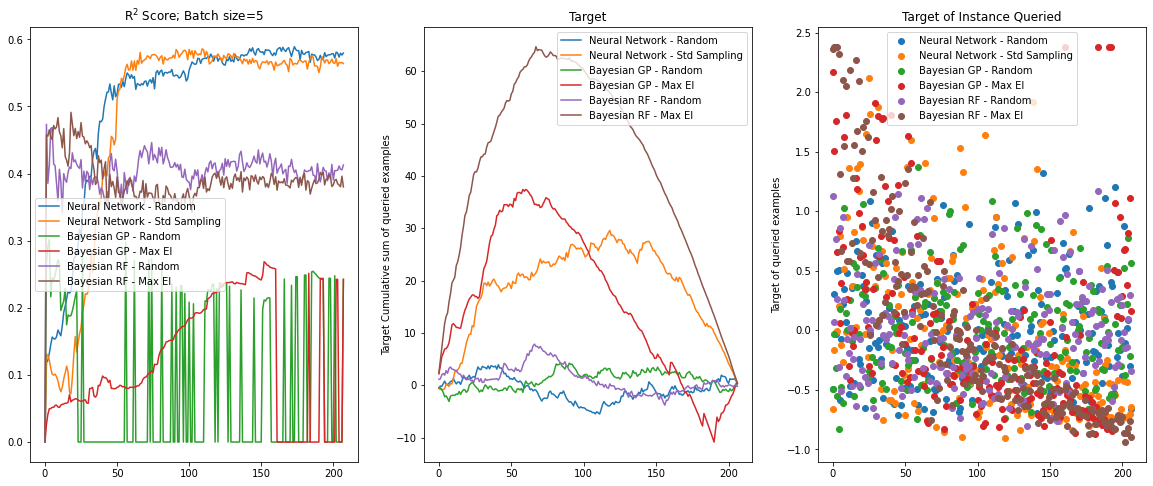

In [ ]:
def train_and_evaluate(X_train, X_test, y_train, y_test, learners, batch_size=1, n_queries=200):
  # Split train & test set: 508/508
  learners_ = dict(); n_feat = len(X_train[0])
  for n_learners, (name, model) in enumerate(learners.items()):
    learners_[name] = {v:None for v in ["model","X_train","y_train","X_batch","y_batch","r2","target (batch)",
                                        "target (overall)"]}
    learners_[name]["model"] = model
    learners_[name]["X_train"], learners_[name]["y_train"] = copy.deepcopy(X_train), copy.deepcopy(y_train)
    learners_[name]["r2"] = [0]
    learners_[name]["target (batch)"] = []
    learners_[name]["target (overall)"] = []
  for idx in range(n_queries): 
    print("Query round",idx,"|Remaining Data Shape",learners_[name]["X_train"].shape);
    # Each batch round initializations
    for name, dict_info in learners_.items():
        learners_[name]["X_batch"] = np.empty((0,n_feat), float)
        learners_[name]["y_batch"] =  np.empty((0,1), float)
    for i in range(batch_size):
      for name, dict_info in learners_.items():
        print("Model:", name)
        query_idx, query_inst = dict_info["model"].query(dict_info["X_train"])
        # add quried yield
        dict_info["target (overall)"].append(float(dict_info["y_train"][query_idx]))
        # stack training data for this batch
        dict_info["X_batch"] = np.vstack((dict_info["X_batch"], query_inst.reshape(1,-1)))
        dict_info["y_batch"] = np.vstack((dict_info["y_batch"], dict_info["y_train"][query_idx].reshape(1,-1)))
        # Remove queried data
        dict_info["X_train"] = np.delete(dict_info["X_train"], query_idx, axis=0)
        dict_info["y_train"] = np.delete(dict_info["y_train"], query_idx) 
      print("Batch size", dict_info["X_batch"].shape, dict_info["y_batch"].reshape(-1,1).shape) 
    for name, dict_info in learners_.items():    
      # Train
      dict_info["model"].teach(dict_info["X_batch"], dict_info["y_batch"].reshape(-1,1))
      # Add results
      dict_info["r2"].append(r2_score(y_test, learners_[name]["model"].predict(X_test)))
      # Mean over the round
      dict_info["target (batch)"].append(np.mean(dict_info["target (overall)"][idx*batch_size:(idx+1)*batch_size]))
      print(idx,"Test R2:", name, dict_info["r2"][-1])
      print("Training data used:", idx*i)
  # Plot Results 
  fig, axes = plt.subplots(1, 3, figsize=(20,8)); ax=axes.ravel(); results = dict()
  for n, (name, dict_info) in enumerate(learners_.items()):
    ax[0].plot(range(idx+2), dict_info["r2"], label=name);
    ax[0].set_title("R$^2$ Score; Batch size="+str(batch_size)); ax[0].legend()
    ax[1].plot(range(idx+1), np.cumsum(dict_info["target (batch)"]), label=name);ax[1].legend()
    ax[1].set_title('Target'); ax[1].set_ylabel('Target Cumulative sum of queried examples')
    ax[2].scatter(range(idx+1), dict_info["target (batch)"], label=name); ax[2].legend()
    ax[2].set_title("Target of Instance Queried"); ax[2].set_ylabel('Target of queried examples')
    # Final prediction
    y_pred = dict_info["model"].predict(X_test)
    results[name] = {"Target":dict_info["target (overall)"],
                      "Final Scores": r2_score(y_test, y_pred), "y_pred": y_pred}
    #print(name," R2 score:", r2_score(dict_info["y_train"], dict_info["model"].predict(X_train)))
  return results, fig


batch_size = 5
n_queries=len(X_train)//batch_size
print(X_train.shape, y_train.shape)

mylearners = {"Neural Network - Random": nn_learner_committee_rand,
              "Neural Network - Std Sampling": nn_learner_committee_std,
              #"Neural Network - UCB": nn_learner_committee_UCB,
              #"Neural Network - Dense": nn_learner_committee_dense,
              #"RF - random": rf_rand,
              #"LR - random": lr_rand,
              #"4 regressor committee - Max std": ensemble_4regressor_std,
              #"2 GP committee - Max std": gp_committee_2_std,
              #"2 GP committee - dense": gp_committee_2_dense,
              #"GP 10 committee - std": gp_committee_10_std,
              "Bayesian GP - Random": bayes_gp_rand,
              "Bayesian GP - Max EI": bayes_gp_maxei,
              "Bayesian RF - Random": bayes_rf_rand,
              "Bayesian RF - Max EI": bayes_rf_maxei
              }
train_history_maxacc, fig = train_and_evaluate(X_train, X_test, y_train, y_test, learners=mylearners, n_queries=n_queries, batch_size=batch_size)
name = "Query comparison.png"
fig.savefig(output_path/name)

In [ ]:
# Save with grand title
fig.suptitle("Lab Simulation Dataset Query Comparison")
fig.savefig(output_path/"Query Comparison - Lab (Reduced) Dataset.jpg")

In [ ]:
# See R2 scores
train_history = train_history_maxacc
for name, dict_info in train_history.items():
    print(name, dict_info['Final Scores'])
# see violin plot for a model
model = "RF - random"
scaled_yield = (np.array(train_history["Neural Network - UCB"]["Yield"])*df_data["Yield"].std()+df_data["Yield"].mean())/batch_size
sb.violinplot(x=np.repeat(range(1,n_queries+1),batch_size), y=scaled_yield)
plt.xlabel("Query round"); plt.ylabel("Mean Yield")

Neural Network - Random 0.18693233795197983
Neural Network - Std Sampling 0.20827947993904017
Bayesian GP - Random 0.20227917164546516
Bayesian GP - Max EI -0.029495724239775534
Bayesian RF - Random 0.501500627559587
Bayesian RF - Max EI 0.39296181448814615


KeyError: ignored